In [1]:
! pip install version_information

In [2]:
! pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (10.0.1)


In [3]:
! pip install tqdm

In [4]:
#https://ipyton.org/ipython-docdex/config/extsions/autoreload.html
%reload_ext autoreload
%autoreload 2

#version information
%reload_ext version_information
%version_information Cython, matplotlib, numpy, pandas,  qutip, seaborn, scipy, sklearn, tqdm, version_information,

Software,Version
Python,3.6.4 64bit [GCC 7.2.0]
IPython,6.3.1
OS,Linux 4.9.87 linuxkit aufs x86_64 with debian stretch sid
Cython,0.28.2
matplotlib,2.1.2
numpy,1.13.3
pandas,0.22.0
qutip,The 'qutip' distribution was not found and is required by the application
seaborn,0.8.1
scipy,1.0.1


# Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. We have aggregated these login counts based on 15­minute time intervals, and visualized. The best characterized underlying patterns of the demand is illustrated below. Notes are data issues/quality are mentioned throughout. See report in folder too.

In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pandas.api.types import CategoricalDtype
import pandas as pd
import seaborn as sns
from six.moves import range
from tqdm import tqdm

#package for time series correlations
from statsmodels.tsa import stattools 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

#import modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score, auc,precision_recall_curve,classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve

#imports for preparing data for sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn. preprocessing import LabelEncoder


#some packages for cleaning and wrangling
from collections import defaultdict
import datetime as dt
import re
from tqdm import tqdm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
#a function break out time information to columns
def make_columns( df, column ):
    """news_df is pandas dataframe from csv for twitter account
    tweet_from is name of twitter accout
    ml_df is the dataframe for doing machine learning in a tidy format"""

    df['yr'] = [r.year for r in df[column] ]
    df['moy'] = [r.strftime('%b') for r in df[column] ]
    df['dow'] = [r.strftime('%a') for r in df[column] ] #zero is Monday
    df['hod'] = [r.hour for r in df[column] ]
    df['moh'] = [r.minute for r in df[column] ]
    df['day'] = [r.day for r in df[column] ]
    df['woy'] = [r.weekofyear for r in df[column] ] #starts at 1 not zero
    df['week'] = [r.week for r in df[column] ]
    df['doy'] = [r.dayofyear for r in df[column] ] #starts at 1 not zero
    
    

In [7]:
#read in json to pandas dataframe
df_logins = pd.read_json('logins.json')
df_logins.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [8]:
#capture start and end points
end_point = max(df_logins['login_time'])
start_point = min(df_logins['login_time'])

# Looking for missing data


In [9]:
df_logins.nunique()

login_time    92265
dtype: int64

In [10]:

df_logins.count()


login_time    93142
dtype: int64

In [11]:
#inspect duplicates
df_logins[df_logins.duplicated(keep=False)]

,login_time
347,1970-01-02 10:59:52
354,1970-01-02 10:59:52
427,1970-01-02 12:27:48
434,1970-01-02 12:27:48
503,1970-01-02 15:08:27
506,1970-01-02 15:08:27
521,1970-01-02 16:14:36
524,1970-01-02 16:14:36
669,1970-01-02 22:03:36
672,1970-01-02 22:11:16



Looks like there are some duplicate logins. This could mean that the system has a bug or that someone logged in at he exact same time. 877 duplicates. We should keep this against login by users to determine if the system has a bug. If the user is differnt then we would want to keep the duplicates. If the user is the same, we would drop duplicates. 

### We are interested in 15 minute windows so we will bin accordingly. 

In [12]:
#make range of datetime periods for 15 mins
bins_pd = pd.period_range(start_point, end_point , freq = '15min')
bins_pd

PeriodIndex(['1970-01-01 20:12', '1970-01-01 20:27', '1970-01-01 20:42',
             '1970-01-01 20:57', '1970-01-01 21:12', '1970-01-01 21:27',
             '1970-01-01 21:42', '1970-01-01 21:57', '1970-01-01 22:12',
             '1970-01-01 22:27',
             ...
             '1970-04-13 16:42', '1970-04-13 16:57', '1970-04-13 17:12',
             '1970-04-13 17:27', '1970-04-13 17:42', '1970-04-13 17:57',
             '1970-04-13 18:12', '1970-04-13 18:27', '1970-04-13 18:42',
             '1970-04-13 18:57'],
            dtype='period[15T]', length=9788, freq='15T')

In [13]:
bins_pd.strftime('%Y-%m-%d %H:%M')

array(['1970-01-01 20:12', '1970-01-01 20:27', '1970-01-01 20:42', ...,
       '1970-04-13 18:27', '1970-04-13 18:42', '1970-04-13 18:57'],
      dtype='<U16')

In [14]:
#strip datetime strings and save for labeling
bins_str = bins_pd.strftime('%Y-%m-%d %H:%M')
bins_str

array(['1970-01-01 20:12', '1970-01-01 20:27', '1970-01-01 20:42', ...,
       '1970-04-13 18:27', '1970-04-13 18:42', '1970-04-13 18:57'],
      dtype='<U16')

In [15]:
#make labels for bins
labels = ['[{}, {})'.format(bins_str[i-1], bins_str[i]) for i in range(1, len(bins_str))]
labels

['[1970-01-01 20:12, 1970-01-01 20:27)',
 '[1970-01-01 20:27, 1970-01-01 20:42)',
 '[1970-01-01 20:42, 1970-01-01 20:57)',
 '[1970-01-01 20:57, 1970-01-01 21:12)',
 '[1970-01-01 21:12, 1970-01-01 21:27)',
 '[1970-01-01 21:27, 1970-01-01 21:42)',
 '[1970-01-01 21:42, 1970-01-01 21:57)',
 '[1970-01-01 21:57, 1970-01-01 22:12)',
 '[1970-01-01 22:12, 1970-01-01 22:27)',
 '[1970-01-01 22:27, 1970-01-01 22:42)',
 '[1970-01-01 22:42, 1970-01-01 22:57)',
 '[1970-01-01 22:57, 1970-01-01 23:12)',
 '[1970-01-01 23:12, 1970-01-01 23:27)',
 '[1970-01-01 23:27, 1970-01-01 23:42)',
 '[1970-01-01 23:42, 1970-01-01 23:57)',
 '[1970-01-01 23:57, 1970-01-02 00:12)',
 '[1970-01-02 00:12, 1970-01-02 00:27)',
 '[1970-01-02 00:27, 1970-01-02 00:42)',
 '[1970-01-02 00:42, 1970-01-02 00:57)',
 '[1970-01-02 00:57, 1970-01-02 01:12)',
 '[1970-01-02 01:12, 1970-01-02 01:27)',
 '[1970-01-02 01:27, 1970-01-02 01:42)',
 '[1970-01-02 01:42, 1970-01-02 01:57)',
 '[1970-01-02 01:57, 1970-01-02 02:12)',
 '[1970-01-02 02

In [16]:
bins_pd[0]

Period('1970-01-01 20:12', '15T')

In [17]:
#convert periods to datetime for calculations later
bins_ts = bins_pd.to_timestamp()
bins_ts

DatetimeIndex(['1970-01-01 20:12:00', '1970-01-01 20:27:00',
               '1970-01-01 20:42:00', '1970-01-01 20:57:00',
               '1970-01-01 21:12:00', '1970-01-01 21:27:00',
               '1970-01-01 21:42:00', '1970-01-01 21:57:00',
               '1970-01-01 22:12:00', '1970-01-01 22:27:00',
               ...
               '1970-04-13 16:42:00', '1970-04-13 16:57:00',
               '1970-04-13 17:12:00', '1970-04-13 17:27:00',
               '1970-04-13 17:42:00', '1970-04-13 17:57:00',
               '1970-04-13 18:12:00', '1970-04-13 18:27:00',
               '1970-04-13 18:42:00', '1970-04-13 18:57:00'],
              dtype='datetime64[ns]', length=9788, freq='15T')

In [18]:
bins_ts[0]

Timestamp('1970-01-01 20:12:00', freq='15T')

In [19]:
bins_ts.astype(np.int64)//10**9

Int64Index([  72720,   73620,   74520,   75420,   76320,   77220,   78120,
              79020,   79920,   80820,
            ...
            8872920, 8873820, 8874720, 8875620, 8876520, 8877420, 8878320,
            8879220, 8880120, 8881020],
           dtype='int64', length=9788)

In [20]:
#make bins of 15 min time intervals
df_logins['bin'] = pd.cut(df_logins.login_time.astype(np.int64)//10**9, #converts datetime values into UNIX epoch 
                   bins=bins_ts.astype(np.int64)//10**9,
                   labels=labels)

#converts datetime values into UNIX epoch 
#(timestamp - # of seconds since 1970-01-01 00:00:00):

In [21]:
df_logins.head()

,login_time,bin
0,1970-01-01 20:13:18,"[1970-01-01 20:12, 1970-01-01 20:27)"
1,1970-01-01 20:16:10,"[1970-01-01 20:12, 1970-01-01 20:27)"
2,1970-01-01 20:16:37,"[1970-01-01 20:12, 1970-01-01 20:27)"
3,1970-01-01 20:16:36,"[1970-01-01 20:12, 1970-01-01 20:27)"
4,1970-01-01 20:26:21,"[1970-01-01 20:12, 1970-01-01 20:27)"


# Now we extract the time components to separate columns and plot.

In [22]:
#call function to extract time columns
make_columns(df_logins, 'login_time')

In [23]:
df_logins.head(5)

,login_time,bin,yr,moy,dow,hod,moh,day,woy,week,doy
0,1970-01-01 20:13:18,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,13,1,1,1,1
1,1970-01-01 20:16:10,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
2,1970-01-01 20:16:37,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
3,1970-01-01 20:16:36,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
4,1970-01-01 20:26:21,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,26,1,1,1,1


In [24]:
#sort by login time, nan upfront, and do inplace
df_logins.sort_values(by='login_time', inplace=True , na_position='first')

In [25]:
df_logins.head(15)

,login_time,bin,yr,moy,dow,hod,moh,day,woy,week,doy
6,1970-01-01 20:12:16,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,12,1,1,1,1
0,1970-01-01 20:13:18,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,13,1,1,1,1
1,1970-01-01 20:16:10,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
3,1970-01-01 20:16:36,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
2,1970-01-01 20:16:37,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,16,1,1,1,1
5,1970-01-01 20:21:41,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,21,1,1,1,1
10,1970-01-01 20:26:05,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,26,1,1,1,1
4,1970-01-01 20:26:21,"[1970-01-01 20:12, 1970-01-01 20:27)",1970,Jan,Thu,20,26,1,1,1,1
11,1970-01-01 20:31:03,"[1970-01-01 20:27, 1970-01-01 20:42)",1970,Jan,Thu,20,31,1,1,1,1
12,1970-01-01 20:34:46,"[1970-01-01 20:27, 1970-01-01 20:42)",1970,Jan,Thu,20,34,1,1,1,1


In [26]:
#groupby 15 minute window
login_bin_15m = df_logins.groupby('bin').count()

In [27]:
login_bin_15m.tail()

,login_time,yr,moy,dow,hod,moh,day,woy,week,doy
bin,,,,,,,,,,
"[1970-04-13 17:42, 1970-04-13 17:57)",4,4,4,4,4,4,4,4,4,4
"[1970-04-13 17:57, 1970-04-13 18:12)",4,4,4,4,4,4,4,4,4,4
"[1970-04-13 18:12, 1970-04-13 18:27)",4,4,4,4,4,4,4,4,4,4
"[1970-04-13 18:27, 1970-04-13 18:42)",5,5,5,5,5,5,5,5,5,5
"[1970-04-13 18:42, 1970-04-13 18:57)",7,7,7,7,7,7,7,7,7,7


In [28]:
login_bin_15m = login_bin_15m.reset_index()

In [29]:
#create labels for x axis
tick_marks=[] #tick labels
tick_index=[] #tick locations
#loop over groupby 15min bins
for i in range( len ( login_bin_15m) ):
    if i%1000==0: #get tick for every 1000th 15 min bin
        tick_marks.append(login_bin_15m.bin.loc[i]) #save bin name
        tick_index.append(i) #save tick index (location)
tick_index.append(max(login_bin_15m.bin.index)) #add label for last tick mark
tick_marks.append(max(login_bin_15m.bin)) #get index of last tick mark

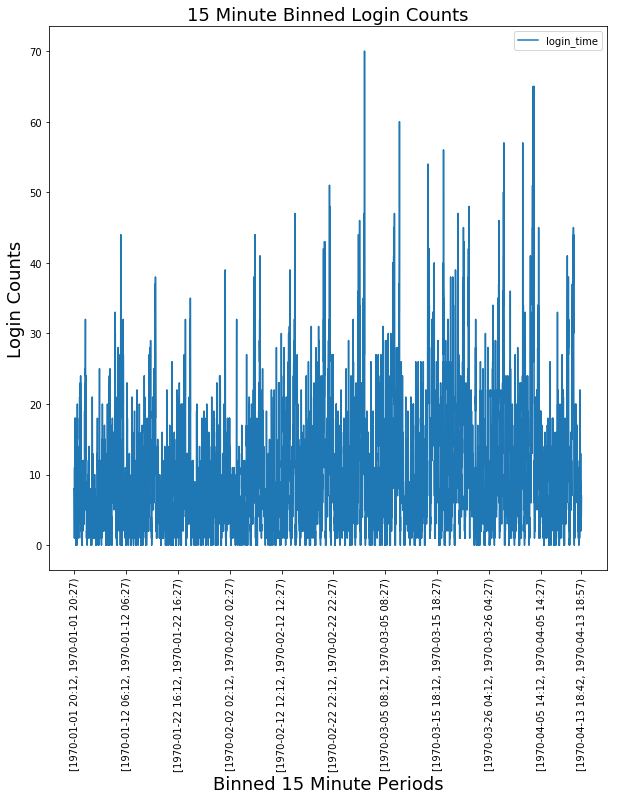

In [30]:
# plot 15 min bins with x tick labels
fig, ax1 = plt.subplots(figsize=(10,10)) #set window size
ax1 = login_bin_15m.login_time.plot(rot=90) #plot bins against login count rotate labels
ax1.xaxis.set_major_locator(MaxNLocator(10))#set 10 tick marks
ax1.set_xticks( tick_index ) #set tick locations
ax1.set_xticklabels(tick_marks) #set tick labels
ax1.legend() #add legend
plt.title('15 Minute Binned Login Counts', fontsize=18)
plt.ylabel('Login Counts', fontsize=18)
plt.xlabel('Binned 15 Minute Periods', fontsize=18)
plt.savefig('15m_bins_plot.png')
plt.show()

We see that per 15 min bins the logins might be increasing slightly most recently. Next we will look more closely by assigning windows for day, week, and month and plotting the mean for these. The mean will help to reduce the noise and uncover possible trends.

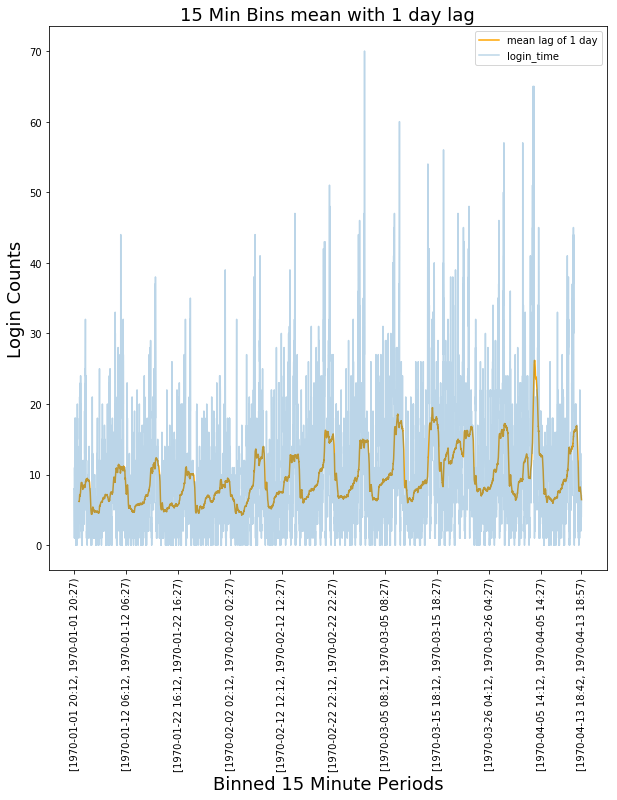

In [31]:
#plot rolling window of 10
fig, ax1 = plt.subplots(figsize=(10,10))
#plot mean for one day of logins
# window is  4*24=96 : 15 min period *4 gets one hour *24 hours
r =login_bin_15m.login_time.rolling(window = 96) #set window
r.mean().plot(style = 'orange', label='mean lag of 1 day')#get mean and plot
#plot raw data for comparation
ax1 = login_bin_15m.login_time.plot(rot=90, alpha=.3)
ax1.xaxis.set_major_locator(MaxNLocator(10))#add 10 ticks
ax1.set_xticks( tick_index )#tick locations
ax1.set_xticklabels(tick_marks,rotation=90)# set tick labels
ax1.legend()# add lengend and labels 
plt.title('15 Min Bins mean with 1 day lag', fontsize=18)
plt.ylabel('Login Counts', fontsize=18)
plt.xlabel('Binned 15 Minute Periods', fontsize=18)
plt.savefig('15m_lag_1day.png') #save fig
plt.show()


Some trends start to present themselves. the spread between peak and trough appears to be growing. Indicating some days have higher demand. We will have to look deeper into which days and why. 

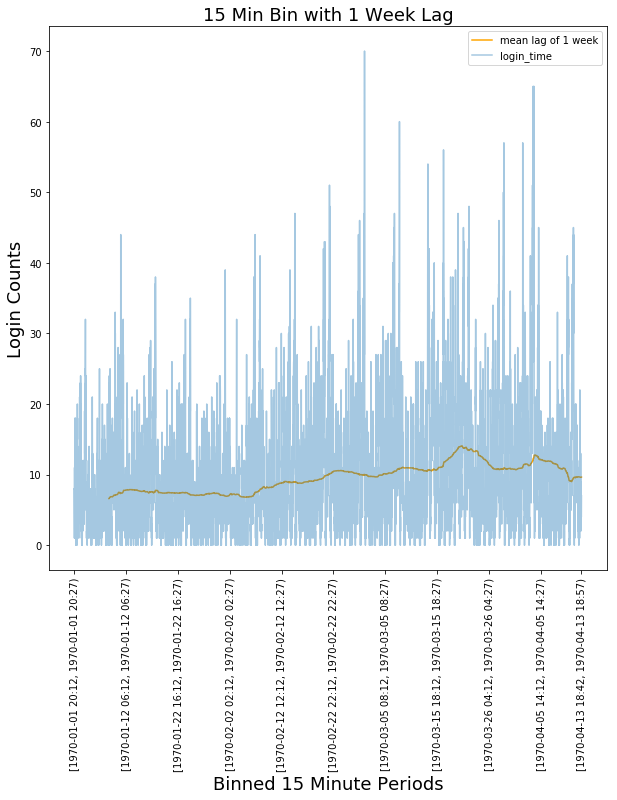

In [32]:
#plot one week mean lag
fig, ax1 = plt.subplots(figsize=(10,10)) #set fig size
#set window for rolling 97*7=672 gets from day to week 
r =login_bin_15m.login_time.rolling(window = 672)
r.mean().plot(style = 'orange', label='mean lag of 1 week') #plot mean

ax1 = login_bin_15m.login_time.plot(rot=90, alpha=.4) #plot org for comparison
ax1.xaxis.set_major_locator(MaxNLocator(10)) # set 10 ticks
ax1.set_xticks( tick_index )#set tick location
ax1.set_xticklabels(tick_marks,rotation=90)#set tick label
ax1.legend()#add legend
plt.title('15 Min Bin with 1 Week Lag', fontsize=18)
plt.ylabel('Login Counts', fontsize=18)
plt.xlabel('Binned 15 Minute Periods', fontsize=18)
#save plot
plt.savefig('15m_lag_1week.png')
plt.show()

The week mean trend presents a concern. The trend seems to have started to decline near the end of the third month. This is something we should discuss with other departments to uncover why? Did the marketing change? Did operations change? Was there bad publicity? It could also be attributed to the weather warming and people choosing to walk more. However, it should be investigate and other departments notified. 

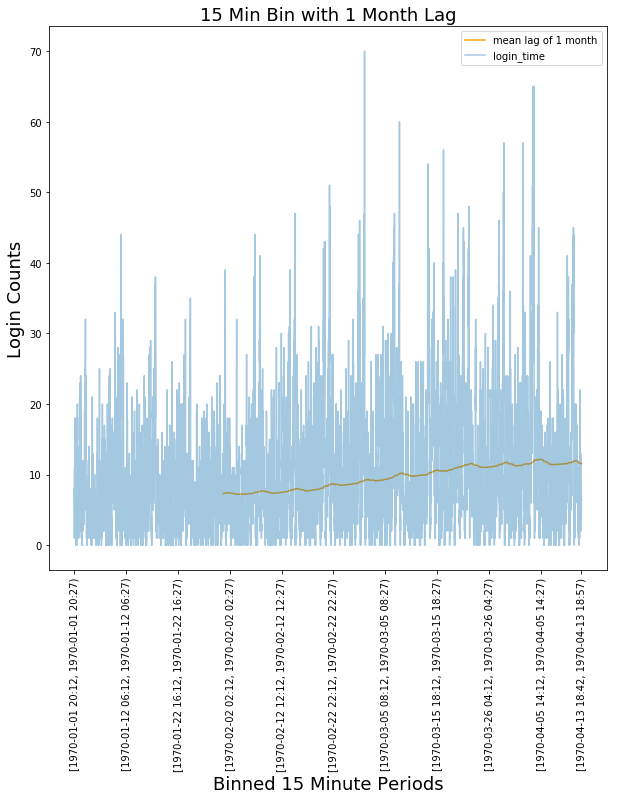

In [33]:
from matplotlib.ticker import MaxNLocator
fig, ax1 = plt.subplots(figsize=(10,10))
#month is 96*30=2880 periods
r =login_bin_15m.login_time.rolling(window = 2880)
r.mean().plot(style = 'orange', label='mean lag of 1 month')
ax1 = login_bin_15m.login_time.plot(rot=90, alpha=.4)
ax1.xaxis.set_major_locator(MaxNLocator(10))
ax1.set_xticks( tick_index )
ax1.set_xticklabels(tick_marks,rotation=90)
ax1.legend()
plt.title('15 Min Bin with 1 Month Lag', fontsize=18)
plt.ylabel('Login Counts', fontsize=18)
plt.xlabel('Binned 15 Minute Periods', fontsize=18)
#save plot
plt.savefig('15m_lag_1month.png')
plt.show()

The month trend highlights the company grow, thus far and removes most of the daily variability. Dropping the raw data (blue lines) this would be a good graph to highlight the company success thus far. The negative week trend is only slightly apparent (leveling off at the right end of the graph). 

# Now some bar charts

In [34]:
df_logins.tail()

,login_time,bin,yr,moy,dow,hod,moh,day,woy,week,doy
93136,1970-04-13 18:48:52,"[1970-04-13 18:42, 1970-04-13 18:57)",1970,Apr,Mon,18,48,13,16,16,103
93137,1970-04-13 18:50:19,"[1970-04-13 18:42, 1970-04-13 18:57)",1970,Apr,Mon,18,50,13,16,16,103
93139,1970-04-13 18:54:02,"[1970-04-13 18:42, 1970-04-13 18:57)",1970,Apr,Mon,18,54,13,16,16,103
93141,1970-04-13 18:54:23,"[1970-04-13 18:42, 1970-04-13 18:57)",1970,Apr,Mon,18,54,13,16,16,103
93140,1970-04-13 18:57:38,NaN,1970,Apr,Mon,18,57,13,16,16,103


In [35]:
#change data to cat for plotting
#want days and month in order
#set label names
days = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
months = [ 'Jan', 'Feb', 'Mar', 'Apr'] #,'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']

#get days in order for 
cat_type = CategoricalDtype(categories=days, ordered=True) #convert to categories to sort
df_logins['dow'] = df_logins['dow'].astype(cat_type) #relabel values in column

#get months in order (same as above)
cat_type = CategoricalDtype(categories=months, ordered=True)
df_logins['moy'] = df_logins['moy'].astype(cat_type)


In [36]:
#group by day of week and month of year counts
dow_gp = df_logins.groupby(  ["dow", 'moy'] ).count()
#check
dow_gp.head()

login_time   bin    yr   hod   moh   day   woy  week   doy
dow moy                                                            
Mon Jan        1926  1926  1926  1926  1926  1926  1926  1926  1926
    Feb        2355  2355  2355  2355  2355  2355  2355  2355  2355
    Mar        3532  3532  3532  3532  3532  3532  3532  3532  3532
    Apr        1010  1009  1010  1010  1010  1010  1010  1010  1010
Tue Jan        2124  2124  2124  2124  2124  2124  2124  2124  2124

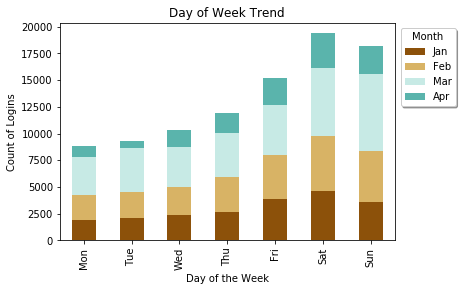

In [37]:
my_colors= ['#8c510a','#d8b365','#c7eae5','#5ab4ac', '#01665e']

#plot day of week with stacked month break out
dow_gp.login_time.unstack().plot(kind='bar', stacked=True, color= my_colors)
plt.title("Day of Week Trend")
plt.ylabel("Count of Logins")
plt.xlabel('Day of the Week')
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1,title='Month')
sns.set() #set style and save
plt.savefig('dow_trend.png')

We see here that the weekend is are busiest time and the beginning of the week the least. Note also, the growth per month. One caveat is that April is not a full month, but only up to the 14th. We should therefore expect around have the size for it then March. This focus on the weekend could explain what we saw earlier in the daily window. Recall that in that graph that the days exhibited sevearl peaks which this graph indicates should correspond to the weekends. 

In [38]:
#group by day of week and month of year counts
moy_gp = df_logins.groupby(  ["moy", 'dow'] ).count()
#check
moy_gp.head()

login_time   bin    yr   hod   moh   day   woy  week   doy
moy dow                                                            
Jan Mon        1926  1926  1926  1926  1926  1926  1926  1926  1926
    Tue        2124  2124  2124  2124  2124  2124  2124  2124  2124
    Wed        2375  2375  2375  2375  2375  2375  2375  2375  2375
    Thu        2640  2640  2640  2640  2640  2640  2640  2640  2640
    Fri        3907  3907  3907  3907  3907  3907  3907  3907  3907

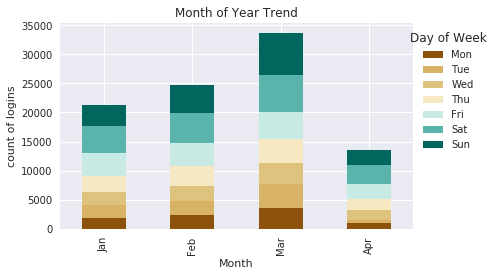

In [39]:

day_colors= ['#8c510a','#d8b365','#dfc27d','#f6e8c3','#c7eae5','#5ab4ac', '#01665e']

#plot day of week with stacked month break out
moy_gp.login_time.unstack().plot(kind='bar', stacked=True, color=day_colors)
plt.title("Month of Year Trend")
plt.ylabel("count of logins")
plt.xlabel('Month')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1, title='Day of Week')

sns.set()#set style
plt.savefig('mow_trend.png')

This the look from the month perspective, which highlights the nice growth we see in the beginning of the year. Once again, April is not a full month so we should only expect at most half. However, we do fall short of that mark. This should be a concern and we should see about what is causing this issue. 

In [40]:
#group by day of week and month of year counts
hod_gp = df_logins.groupby(  ["hod"] ).count()
#check
hod_gp.head()

,login_time,bin,yr,moy,dow,moh,day,woy,week,doy
hod,,,,,,,,,,
0,5993,5993,5993,5993,5993,5993,5993,5993,5993,5993
1,6317,6317,6317,6317,6317,6317,6317,6317,6317,6317
2,5800,5800,5800,5800,5800,5800,5800,5800,5800,5800
3,4831,4831,4831,4831,4831,4831,4831,4831,4831,4831
4,5034,5034,5034,5034,5034,5034,5034,5034,5034,5034


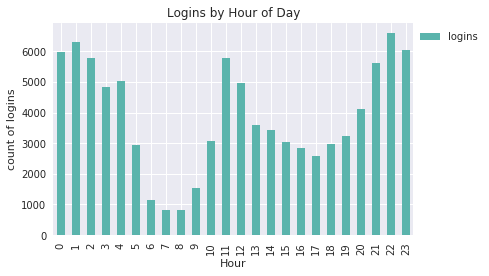

In [41]:
#plot day of week with stacked month break out
hod_gp.login_time.plot(kind='bar', color='#5ab4ac', label='logins')
plt.title("Logins by Hour of Day")
plt.ylabel("count of logins")
plt.xlabel('Hour')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1)

sns.set() #set style and save
plt.savefig('hod_trend.png')

The hour trend highlights that our customers login in heavily around non and late in the evening. The noon activity is probably associated with catching rides to and from lunch. The evening activity can be explained if we take in the increase in weekend activity to being contributed to from going out. We could use this knowledge of our customers to tailor driver allocation saving costs. We could also use this to tailor marketing in an effort to dominate this section of the industry. 

In [42]:
#group by day of week and month of year counts
moh_gp = df_logins.groupby(  ["moh"] ).count()
#check
moh_gp.head()

,login_time,bin,yr,moy,dow,hod,day,woy,week,doy
moh,,,,,,,,,,
0,1539,1539,1539,1539,1539,1539,1539,1539,1539,1539
1,1461,1461,1461,1461,1461,1461,1461,1461,1461,1461
2,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491
3,1492,1492,1492,1492,1492,1492,1492,1492,1492,1492
4,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471


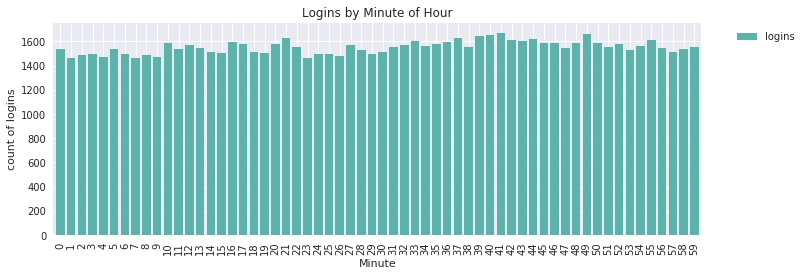

In [43]:
#plot day of week with stacked month break out
#set fig size
plt.figure(figsize=(10,4))
#plot
moh_gp.login_time.plot(kind='bar', color='#5ab4ac',width=0.8, label='logins')
#labels and titles
plt.title("Logins by Minute of Hour")
plt.ylabel("count of logins")
plt.xlabel('Minute')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1)

sns.set()
plt.savefig('mof_trend.png')

The login by minute is uniform for the hour, which is what we would hope to see. 

In [44]:
#group by day of week and month of year counts
woy_gp = df_logins.groupby(  ["woy"] ).count()
#check
woy_gp.head()

,login_time,bin,yr,moy,dow,hod,moh,day,week,doy
woy,,,,,,,,,,
1,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374
2,5217,5217,5217,5217,5217,5217,5217,5217,5217,5217
3,5023,5023,5023,5023,5023,5023,5023,5023,5023,5023
4,4751,4751,4751,4751,4751,4751,4751,4751,4751,4751
5,4744,4744,4744,4744,4744,4744,4744,4744,4744,4744


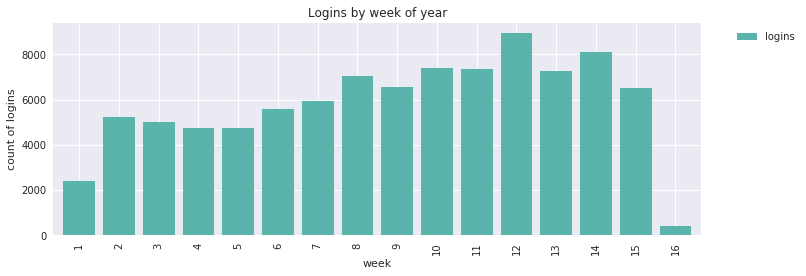

In [45]:
#plot day of week with stacked month break out
plt.figure(figsize=(10,4))
woy_gp.login_time.plot(kind='bar', color='#5ab4ac',width=0.8, label='logins')
plt.title("Logins by week of year")
plt.ylabel("count of logins")
plt.xlabel('week')

plt.tight_layout()
#move legend outside 
plt.legend(loc='upper center', bbox_to_anchor=(1.1,1),
          fancybox=True, shadow=True, ncol=1)

sns.set()

plt.savefig('woy_trend.png')

The week of year trend highligts our growth per week. We do see that slight decrease most recently, which we have already discussed.

# Time Series Analysis

recall the orginal 15 min data

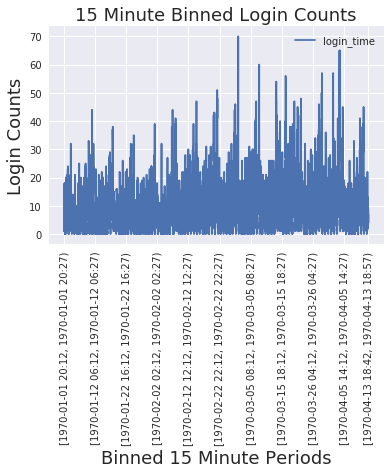

In [46]:
ax1 = login_bin_15m.login_time.plot(rot=90) #plot bins against login count rotate labels
ax1.xaxis.set_major_locator(MaxNLocator(10))#set 10 tick marks
ax1.set_xticks( tick_index ) #set tick locations
ax1.set_xticklabels(tick_marks) #set tick labels
ax1.legend() #add legend
plt.title('15 Minute Binned Login Counts', fontsize=18)
plt.ylabel('Login Counts', fontsize=18)
plt.xlabel('Binned 15 Minute Periods', fontsize=18)
plt.show()

Time series analysis requires are data to be stationary. Lets check the data for stationary using the Dicky Fuller test.

Tests whether a unit root is present in an autoregressive model.

Gives values to assess significance with p-values. P having unit value means its not stationary. 

In [47]:
#apply dicky fuller test
result = adfuller(login_bin_15m.login_time)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -10.437976
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The Dickey-Fuller test.
The results show that -10.437976 is smaller than the critical value at 1% of -3.431. We can reject the null hypothesis with a significance level of less than 1%.

Rejecting the null hypothesis means that the process has no unit root. The time series is probably stationary or lacks time-dependent structure.

If we failed to reject then we would detrend. 

 

##  To detrend we could do this:
We take the difference to remove the linear trends. We lose mean information by doing so. 

We take the log (or power function) to remove variance increase over time.

## Once in stationary form, 
we look at auto-correlation and partial auto-correlation, part of an ARIMA forecast. 

some gerenal information:
Statistical correlation summarizes the strength of the relationship between two variables.

The correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

Auto-correlation identifies possible internal structure related by temporal distance. It is a for finding repeating patterns obscured by noise. It looks at direct correlation but also captures residual correlation from all previous data points.

Checking auto-correlation has one issue to check, if repeated correlation of shorter peroids is persistant (the residual correlation), this is what checking Partial Auto-Correlation accounts for.

Partial Auto Correlation identifies correlations that can be explained by shorter (earlier) correlations.


In forecasting:

The lag values for the Autoregression (AR) and Moving Average (MA) help determine parameters, p and q respectively in the ARIMA model. 

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.



How to read: 
Note: first point is always one. Data point is always perfectly correlated to itself. If the next point is above the significance area then that point has some corelation to the point before it. This means that logins for the period before has a direct affect on the present period of logins. 

Echo (the recurring peaks) is partial correlation presence. 

We would expect the ACF for time series correlations to present a lag and the echo of that relationship to present itself in subsequent lag values, trailing off as the effect weakens. 

x-axis values correspond to lag. 1 unit corresponds to 1 point in the next period. (so 12, 24, 36 would be yearly if monthly period~we are using 15 mins so 4,8,12... would be a daily trend)

shaped blue area is standard signifcance default is 95% (here). In 95% confidence we should expect some spikes (1 in 20). The shorter the time series the more likely the spikes.

for PACF plots:

They try to remove these echos. We would then expect not to see trailing affects. Points outside the confidence interval then tell us more about the time series correlation 

## We can also use these graphs to pull out moving average model information.

ACF should show a strong correlation with recent values up to the lag followed by a decline.

PACF should show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Take aways:
Look for values outside the confidence band in ACF and confirm with PACF for AR values (autocorrelations). PACF is more important in determining AR parameter.  
Look for trailing affects in PACF for MA parameters. 

Look at ACF for MA(moving average) parameters. Find point outside confidence band followed by sharp decline.



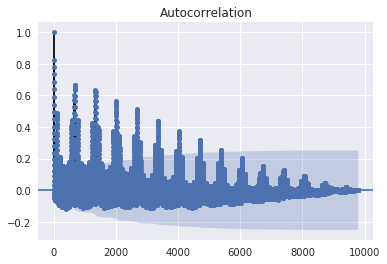

In [48]:
#plot autocorrelation function (acf)
plot_acf(login_bin_15m.login_time, ax=plt.gca(), fft=True)
#save figure
plt.savefig('15_bin_acf.png')

This is a plot of the entire data set. We see that we do have some autocorrelation present. If we play with the lags we can draw some more information out. This is the plotted 15 min bins so 4 bins is an hour, 96 is a day, 672 is a week and 2,880 is a month. Lets play with the bins to see if we can determine some correlations. 

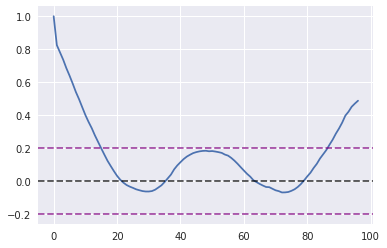

In [49]:
#plot autocorrelation (ACF) for one day
acf_15m_day= stattools.acf(login_bin_15m.login_time ,nlags=96)
acf_15m_day

#plot auto-correlation
plt.plot(acf_15m_day) #set to 4 periods times 24 hours = 1 day
#plot h-axis
plt.axhline(y=0, linestyle= '--', color='k', alpha=.7)

#set standard signifance cutoff
plt.axhline(y=-1.96/np.sqrt( len (acf_15m_day) ) , linestyle='--', color='purple', alpha=.7)

plt.axhline(y=1.96/np.sqrt( len (acf_15m_day) ) , linestyle='--', color='purple', alpha=.7)

Here we see that days exhibit a pattern. Before 17 some correlation is present. We also note another peak between 30 and 65 just touching significance. This would led me to infer some monthly correlation among login activity.  

We should check this against the partial autocorrelation.

Text(0.5,1,'PACF for daily')

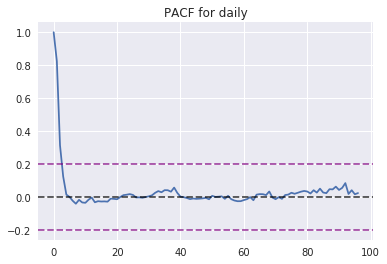

In [50]:

#calculate partial auto-correlation for the daily logins
acf_15m_day= stattools.pacf(login_bin_15m.login_time ,nlags=96)
acf_15m_day

#plot auto-correlation
plt.plot(acf_15m_day) #set to 4 periods = 1 day
#plot h-axis
plt.axhline(y=0, linestyle= '--', color='k', alpha=.7)

#set standard signifance cutoff
plt.axhline(y=-1.96/np.sqrt( len (acf_15m_day) ) , linestyle='--', color='purple', alpha=.7)

plt.axhline(y=1.96/np.sqrt( len (acf_15m_day) ) , linestyle='--', color='purple', alpha=.7)

plt.title("PACF for daily")

The PACF tells us that the day before login activity accounts for most of the correlation on the present time period. 

I would then initially set my ARIMA model with AR one and moving average 17. 

If more time was available we could continue and look at ARIMA forecast modeling, but for now we will recap the login data and move onto parts II and III.

We found out that logins are heaviest on weekends probably associated with going out for the evening. The lunch hour is also a time of peak usage probably more associated with the weekday activity. The morning and afternoon commute times were low.

Recommend targeting week commute usage for new growth areas. We could offer a subscription service with discounted rate or package deal for weekday preplanned pickups. We could also try to be the industry leader for lunch and evening activities targeting these markets. Ads highlighting quick and dependable lunch runs, or safe and responsible evening travel planning are two ideas.

The slowing growth trend is a concern we should focus on. Cross communication with marketing and operation teams to identify and correct immediately should be priority. 


## Part II. Experiment and Metric Design
	
  The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  I would select the mean of the toll per day over a month as the key metric to measure success. 
  
  Measuring tolls gives a measure of how many drivers crossed from one city to the next. The mean will help to adjust observations to the central tendency of behavior, reducing variation for outliers and observation spread. If the experiment is successful, we should see an uptick in the number of tolls after the policy begins compared to the months before the policy. This would indicate that more drivers are commuting to the other city, what we want. (Means also exhibit nice statistical properties which allow us to use some well understood mathematical theories like the central limit theory.) 
  
  A practical experiment to test this policy can be done as follow. Group A is the drivers without reimbursement. Group B is the drivers with reimbursement. Group A will be drivers selected from before the policy implementation, and Group B drivers after. Calculate the tolls per day for each driver and divide by the number of drivers to get the mean toll per day for a driver. We will use the two sample test t test and bootstrap to test the hypothesis. We have two sample sets that we can compare, so the two sample test is preferred over the one sample. We choose to use the bootstrap over the permutation test, since the versatility of the permutation test is limited to testing if samples come from the same distribution. We use the t-test instead of the z-test. The t-test is know to work for larger samples as well as smaller samples. To do the two-sample bootstrap test, we sample a set number from group A and group B. We shift both sets to have the same mean. This allows us to simulate the hypothesis that their means are equal. We then draw bootstrap samples out of the shifted sets and compute the difference in means. We draw several bootstrap replicate. The p-value is the fraction of replicates with a difference in means less than or equal to what was observed. If the p value is extremely small, we reject the hypothesis that the means are in fact the same, which tells us that the policy has statistical significance. Depending on if the mean increased or decreased, the policy is then statistically significant in increasing or decreasing toll usage. We can in this business case then infer that the policy increased or decreased driver availability for both cities. 
  
  If the experiment results conclude that the policy is statistically significant at increasing toll usage thus driver availability, we would recommend keeping the policy. If the experiment show negative or no change in improving driver availability, the policy can be discontinued.  Discontinuous should be weighed against cost and driver relations before canceling. One caveat, the sample size available has to be considered. The test period might need to be expanded for better results. Variations to the experiment are available. Could do an A/B test with select drivers before rolling out company wide. 



# Part III. Predictive Modeling
We would like you to use the data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

Ultimate is interested in predicting rider retention. To help explore this question, we have a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [51]:
import json

In [52]:

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)


# load data and check quality

In [53]:
df_riders = pd.DataFrame(data)
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [54]:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [55]:
df_riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


The ranges don't see to far out of line.

In [56]:
df_riders.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
ultimate_black_user          2
weekday_pct                666
dtype: int64

In [57]:
#convert column to datetime
df_riders.last_trip_date = pd.to_datetime(df_riders.last_trip_date)

In [58]:
type(df_riders.last_trip_date[0])

pandas._libs.tslib.Timestamp

In [59]:
df_riders.last_trip_date[0]

Timestamp('2014-06-17 00:00:00')

In [60]:
#convert column to datetime
df_riders.signup_date = pd.to_datetime(df_riders.signup_date)

In [61]:
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


Interested in predicting retained riders at 6 months so will use that as our time mark.


In [62]:
#set a time span of 6 months (30 days at 6 months)
months_6 = pd.Timedelta(days=180)

In [63]:
df_riders.count()

avg_dist                  50000
avg_rating_by_driver      49799
avg_rating_of_driver      41878
avg_surge                 50000
city                      50000
last_trip_date            50000
phone                     49604
signup_date               50000
surge_pct                 50000
trips_in_first_30_days    50000
ultimate_black_user       50000
weekday_pct               50000
dtype: int64

Lets explore signup growth in its own dataframe. We will use our function from before to extract time columns.

In [64]:
df_rider_signup= pd.DataFrame(df_riders.signup_date)

In [65]:
make_columns(df_rider_signup,'signup_date' )
df_rider_signup

,signup_date,yr,moy,dow,hod,moh,day,woy,week,doy
0,2014-01-25,2014,Jan,Sat,0,0,25,4,4,25
1,2014-01-29,2014,Jan,Wed,0,0,29,5,5,29
2,2014-01-06,2014,Jan,Mon,0,0,6,2,2,6
3,2014-01-10,2014,Jan,Fri,0,0,10,2,2,10
4,2014-01-27,2014,Jan,Mon,0,0,27,5,5,27
5,2014-01-09,2014,Jan,Thu,0,0,9,2,2,9
6,2014-01-24,2014,Jan,Fri,0,0,24,4,4,24
7,2014-01-28,2014,Jan,Tue,0,0,28,5,5,28
8,2014-01-21,2014,Jan,Tue,0,0,21,4,4,21
9,2014-01-03,2014,Jan,Fri,0,0,3,1,1,3


In [66]:
gp_signup = df_rider_signup.groupby('signup_date').count()
gp_signup.head()

,yr,moy,dow,hod,moh,day,woy,week,doy
signup_date,,,,,,,,,
2014-01-01,1737,1737,1737,1737,1737,1737,1737,1737,1737
2014-01-02,1004,1004,1004,1004,1004,1004,1004,1004,1004
2014-01-03,1213,1213,1213,1213,1213,1213,1213,1213,1213
2014-01-04,1485,1485,1485,1485,1485,1485,1485,1485,1485
2014-01-05,1343,1343,1343,1343,1343,1343,1343,1343,1343


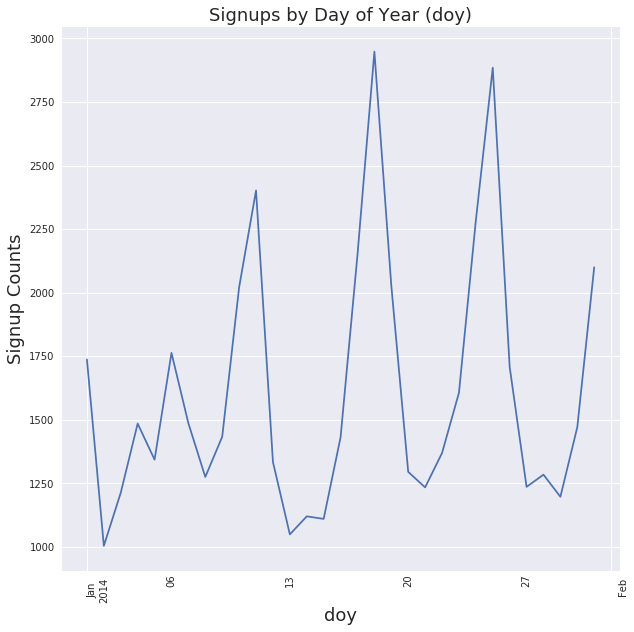

In [67]:
# plot 15 min bins with x tick labels
fig, ax1 = plt.subplots(figsize=(10,10)) #set window size
ax1 = gp_signup.doy.plot(rot=90) #plot bins against login count rotate labels
#plt.plot(x = df_rider_signup.signup_date )
plt.title('Signups by Day of Year (doy)', fontsize=18)
plt.ylabel('Signup Counts', fontsize=18)
plt.xlabel('doy', fontsize=18)
plt.savefig('signup_plot.png')
plt.show()

A lot of fluctuation around signups with a possible postive trend.


Next lets look at last ride in its own dataframe and extracting the time columns.

In [68]:
df_rider_last= pd.DataFrame(df_riders.last_trip_date)

In [69]:
make_columns(df_rider_last,'last_trip_date' )
df_rider_last.head()

,last_trip_date,yr,moy,dow,hod,moh,day,woy,week,doy
0,2014-06-17,2014,Jun,Tue,0,0,17,25,25,168
1,2014-05-05,2014,May,Mon,0,0,5,19,19,125
2,2014-01-07,2014,Jan,Tue,0,0,7,2,2,7
3,2014-06-29,2014,Jun,Sun,0,0,29,26,26,180
4,2014-03-15,2014,Mar,Sat,0,0,15,11,11,74


In [70]:
gp_last = df_rider_last.groupby('last_trip_date').count()
gp_last.head()

,yr,moy,dow,hod,moh,day,woy,week,doy
last_trip_date,,,,,,,,,
2014-01-01,128,128,128,128,128,128,128,128,128
2014-01-02,180,180,180,180,180,180,180,180,180
2014-01-03,128,128,128,128,128,128,128,128,128
2014-01-04,199,199,199,199,199,199,199,199,199
2014-01-05,270,270,270,270,270,270,270,270,270


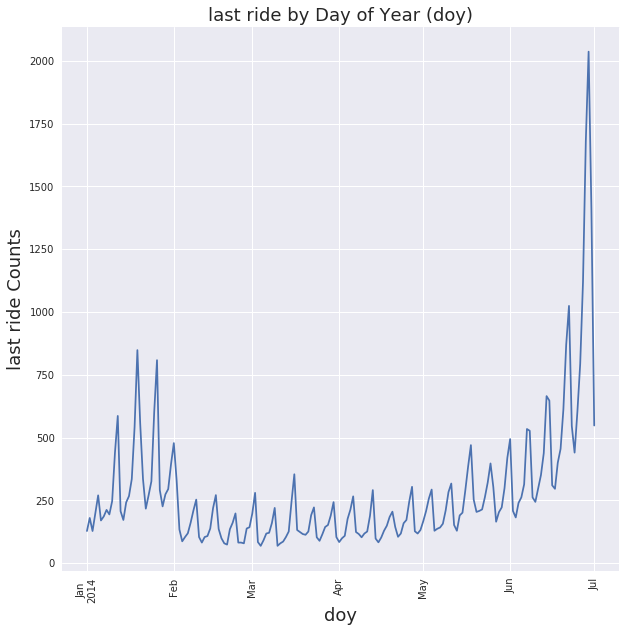

In [71]:
# plot 15 min bins with x tick labels
fig, ax1 = plt.subplots(figsize=(10,10)) #set window size
ax1 = gp_last.doy.plot(rot=90) #plot bins against login count rotate labels
#plt.plot(x = df_rider_signup.signup_date )
plt.title('last ride by Day of Year (doy)', fontsize=18)
plt.ylabel('last ride Counts', fontsize=18)
plt.xlabel('doy', fontsize=18)
plt.savefig('last_ride_plot.png')
plt.show()

The company has a nice trend increasing since May. This graph shows that people are taking more rides with the company. 


# check for missing values

In [72]:
#check for nan
df_riders.isna().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

Machine Learning will not work with NaN values so we need to discard these columns or fill the NaN values. These columns look fairly important. Maybe an indicator of the user experience with the driver, so lets keep these. Looking at the NaN most seem to be associated with new riders who have not taken enough rides. We will replace these NaN values with the mean of the column. This in essence we are saying these customers will rate and be rated along the aggregate of the other users. This preserves the aggregated information as a whole but misrepresents this individual. This could be a problem with accurately predicting new members in our model. The other options is to disregard these rows all together, but then we don't predict for them at all. We could replace with zero but that will skew the values for all riders by pulling down the scores. The mean therefore is the best option. It treats new members as the average member (which is a reasonable guess with no information). 

In [73]:
#check for nan with mean for both
df_riders['avg_rating_by_driver'].fillna(value=df_riders.avg_rating_by_driver.mean(),inplace=True)


In [74]:
df_riders['avg_rating_of_driver'].fillna(value=df_riders.avg_rating_of_driver.mean(),inplace=True)



In [75]:
#check for nan
df_riders.isna().any()

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

In [76]:
 df_riders.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


# EDA
Start by plotting each feature (since there are not to many).

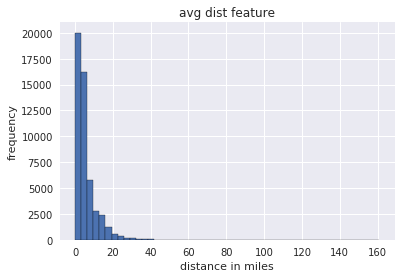

In [77]:
plt.hist(df_riders.avg_dist, bins=50, edgecolor='k')
plt.xlabel('distance in miles')
plt.ylabel('frequency')
plt.title('avg dist feature')
plt.show()

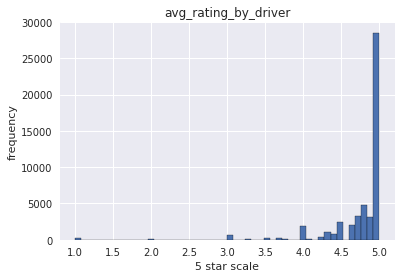

In [78]:
plt.hist(df_riders.avg_rating_by_driver, bins=50, edgecolor='k')
plt.xlabel('5 star scale')
plt.ylabel('frequency')
plt.title('avg_rating_by_driver')
plt.show()

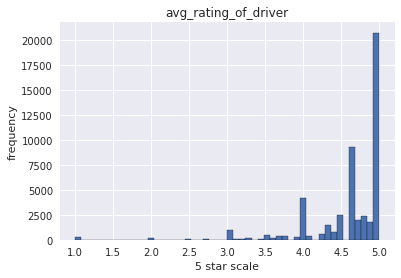

In [79]:
plt.hist(df_riders.avg_rating_of_driver, bins=50, edgecolor='k')
plt.xlabel('5 star scale')
plt.ylabel('frequency')
plt.title('avg_rating_of_driver')
plt.show()

In [80]:
df_riders.avg_surge.describe()

count    50000.000000
mean         1.074764
std          0.222336
min          1.000000
25%          1.000000
50%          1.000000
75%          1.050000
max          8.000000
Name: avg_surge, dtype: float64

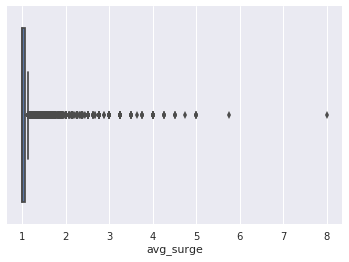

In [81]:
sns.boxplot(df_riders.avg_surge)


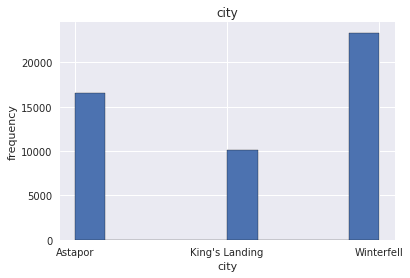

In [82]:
plt.hist(df_riders.city,  edgecolor='k')
plt.xlabel('city')
plt.ylabel('frequency')
plt.title('city')
plt.show()

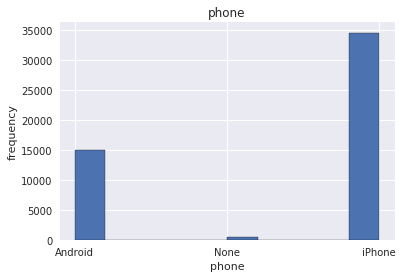

In [83]:
plt.hist(df_riders.phone,  edgecolor='k')
plt.xlabel('phone')
plt.ylabel('frequency')
plt.title('phone')
plt.show()

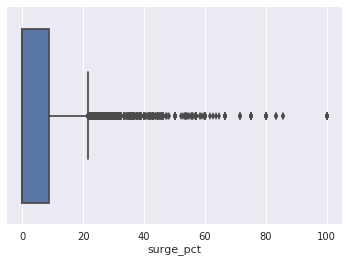

In [84]:
sns.boxplot(df_riders.surge_pct)


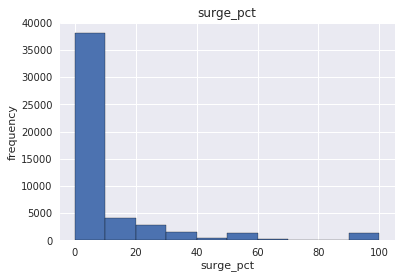

In [85]:
plt.hist(df_riders.surge_pct,  edgecolor='k')
plt.xlabel('surge_pct')
plt.ylabel('frequency')
plt.title('surge_pct')
plt.show()

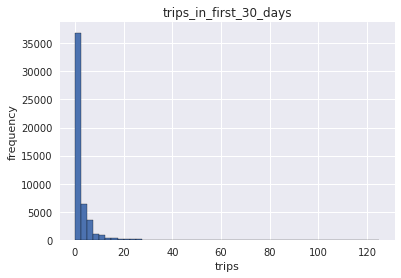

In [86]:
plt.hist(df_riders.trips_in_first_30_days, bins=50 , edgecolor='k')
plt.xlabel('trips')
plt.ylabel('frequency')
plt.title('trips_in_first_30_days')
plt.show()

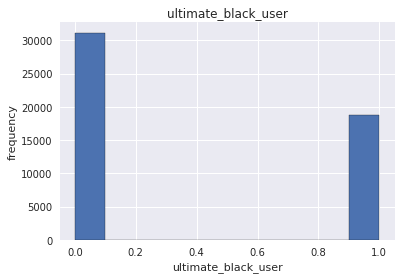

In [87]:
plt.hist(df_riders.ultimate_black_user, edgecolor='k')
plt.xlabel('ultimate_black_user')
plt.ylabel('frequency')
plt.title('ultimate_black_user')
plt.show()

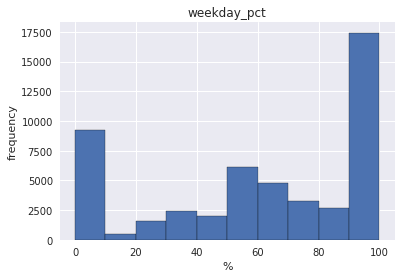

In [88]:
plt.hist(df_riders.weekday_pct, edgecolor='k')
plt.xlabel('%')
plt.ylabel('frequency')
plt.title('weekday_pct')
plt.show()

Text(0.5,1,'weekday percent boxplot ')

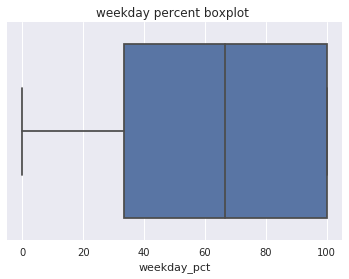

In [89]:
sns.boxplot(df_riders.weekday_pct)
plt.title('weekday percent boxplot ')

Look at inactive riders

In [90]:
#day of data available
last_day = max(df_riders.last_trip_date )

In [91]:
#calculate inactive days
df_riders["days_inactive"] = (last_day - df_riders.last_trip_date)

In [92]:
#turn days into floats for calculations
df_riders["days_inactive"] =[i.total_seconds()/ (24 * 60 * 60) for i in df_riders["days_inactive"]]

In [93]:
df_riders["days_inactive"]=df_riders["days_inactive"].astype('int')

The company defines "active” as (i.e. took a trip) in the preceding 30 days, so we will call inactive not having taken a trip in longer than 30 days. 

In [94]:
#look at only inactive riders
df_inactive_riders = df_riders[df_riders["days_inactive"]>30]

In [95]:
df_inactive_riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,days_inactive
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000
mean,6.207939,4.787415,4.606309,1.075339,8.666739,1.658482,60.647032,110.080651
std,6.238675,0.503312,0.591282,0.251361,22.179139,2.654222,40.982688,48.349012
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,31.000000
25%,2.320000,4.800000,4.500000,1.000000,0.000000,0.000000,16.700000,63.000000
50%,4.030000,5.000000,4.800000,1.000000,0.000000,1.000000,69.600000,114.000000
75%,7.800000,5.000000,5.000000,1.000000,0.000000,2.000000,100.000000,157.000000
max,129.890000,5.000000,5.000000,8.000000,100.000000,73.000000,100.000000,181.000000


Notice hear that most inactive riders only took 2 trips in the first 30 days. Most only traveled between 2 and 8 miles. The ratings were high for and by the drivers. The surge percent seems reasonable too. 60% used it during the weekday. 

In [96]:
((df_riders.signup_date.count() - df_inactive_riders.signup_date.count())/df_riders.signup_date.count())*100

37.608000000000004

# What fraction of the observed users were retained?
37.6% of users were retained.

In [97]:
df_inactive_riders.count()

avg_dist                  31196
avg_rating_by_driver      31196
avg_rating_of_driver      31196
avg_surge                 31196
city                      31196
last_trip_date            31196
phone                     30933
signup_date               31196
surge_pct                 31196
trips_in_first_30_days    31196
ultimate_black_user       31196
weekday_pct               31196
days_inactive             31196
dtype: int64

In [98]:
df_inactive_riders.sum()

avg_dist                                                             193663
avg_rating_by_driver                                                 149348
avg_rating_of_driver                                                 143698
avg_surge                                                           33546.3
city                      AstaporAstaporWinterfellAstaporWinterfellWinte...
surge_pct                                                            270368
trips_in_first_30_days                                                51738
ultimate_black_user                                                    9357
weekday_pct                                                     1.89194e+06
days_inactive                                                       3434076
dtype: object

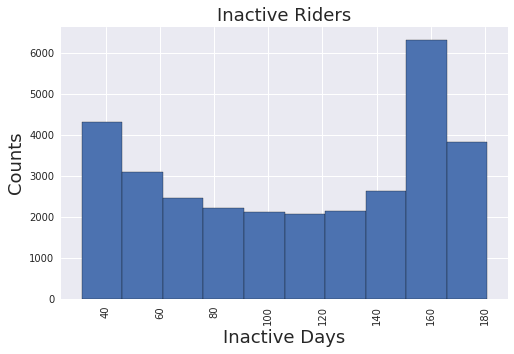

In [99]:
# plot 15 min bins with x tick labels
fig, ax1 = plt.subplots(figsize=(8,5)) #set window size
ax1 = df_inactive_riders["days_inactive"].plot(rot=90, kind ='hist', edgecolor='k') #plot bins against login count rotate labels
#plt.hist(rider_period)
plt.title('Inactive Riders', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Inactive Days', fontsize=18)
plt.savefig('inactive_hist.png')
plt.show()

We see a bimodal histogram. This indicates we might be best to split this into two distributions. This would seem to make sense in reference to riders. The early peak being first time users and the second peak associated with the longer term rider base. In future analysis I would recommend looking at these two groups separately to improve results. However, it is acceptable to continue.

In [100]:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
days_inactive             50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


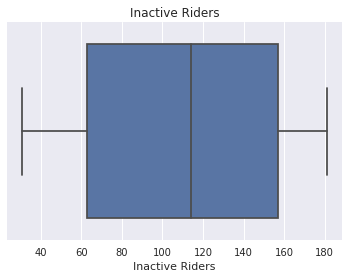

In [101]:
#plot box plot
sns.set()
sns.boxplot(x="days_inactive" , data= df_inactive_riders , orient='h')

# Label the axes
plt.xlabel('Inactive Riders')
plt.ylabel('')
plt.title("Inactive Riders")

plt.savefig('boxplot_inactive_riders.png')
# Show the plot
plt.show()

Here we get a picture of outliers for inactivity. 

We want to do some predictions, so now lets label the data. 

In [102]:
#make labels for machine learning
#zero if inactive zero if active
df_riders['label'] = [0 if df_riders.loc[i,'days_inactive'] > 30 else 1 for i in range (len(df_riders))]

This is a decision point for our model. What to label positive? The problem strictly stated predict who will be with the company. We will therefore label inactive riders zero and active riders one. That is we will predict who is with us and not who is leaving. 
    I would however recommend reframing the question and predict the other that is the churners. This will have some bearing on the metric we use to evaluate the model. More on that then. But for now we will proceed with predicting active users.

In [103]:
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_inactive,label
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,0


Lets take one more moment to see how long customers have been with the company.

In [104]:
rider_period= df_riders.last_trip_date - df_riders.signup_date

In [105]:
#rider_period.total_seconds() / (24 * 60 * 60) 
rider_perid_float = pd.Series([i.total_seconds()/ (24 * 60 * 60) for i in rider_period])

In [106]:
#convert timedelta to float
type( rider_period[0].total_seconds() / (24 * 60 * 60) )

float

In [107]:
pd.DataFrame([i.total_seconds()/ (24 * 60 * 60) for i in rider_period])

,0
0,143.0
1,96.0
2,1.0
3,170.0
4,47.0
5,148.0
6,1.0
7,1.0
8,11.0
9,2.0


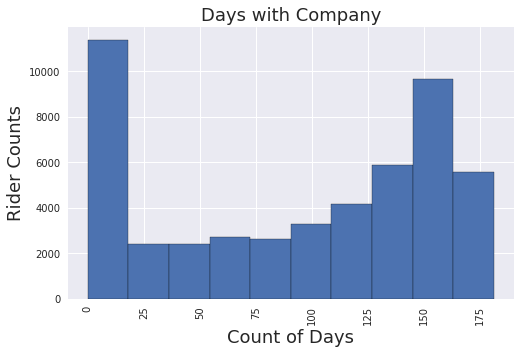

In [108]:
# plot 15 min bins with x tick labels
fig, ax1 = plt.subplots(figsize=(8,5)) #set window size
ax1 = rider_perid_float.plot(rot=90, kind ='hist',edgecolor='k') #plot bins against login count rotate labels
#plt.hist(rider_period)
plt.title('Days with Company', fontsize=18)
plt.ylabel('Rider Counts', fontsize=18)
plt.xlabel('Count of Days', fontsize=18)
plt.savefig('days_with_hist.png')
plt.show()

Looking at this chart I see another bimodal histogram. The new customer that is trying the service out and the long term customer. We could split this into two groups and tailor our approach for each. If more time was allowed we would do this. For now we will see if we can find any common predictions and trends over the whole customer base. 

In [109]:
df_riders['rider_period']=rider_perid_float

In [110]:
 df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_inactive,label,rider_period
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,1,143.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,0,96.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,0,1.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,1,170.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,0,47.0


# preprocess data for modeling
one hot encode categorical data 

In [111]:
#use pandas one hot encoder on data frame
df_riders = pd.get_dummies(df_riders)
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_inactive,label,rider_period,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,14,1,143.0,0,1,0,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,57,0,96.0,1,0,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,175,0,1.0,1,0,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,2,1,170.0,0,1,0,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,108,0,47.0,0,0,1,1,0


In [112]:
#one hot encode black user
df_black = pd.get_dummies(df_riders.ultimate_black_user , prefix='black_user')

In [113]:
#merge black users back encoding into dataframe 
df_riders = pd.merge(df_riders, df_black, how= 'inner',left_index= True, right_index=True)
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_inactive,label,rider_period,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,black_user_False,black_user_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,14,1,143.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,57,0,96.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,175,0,1.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,2,1,170.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,108,0,47.0,0,0,1,1,0,1,0


# lets revisit inactive riders quickly

In [114]:
df_inactive_riders = df_riders[df_riders["days_inactive"]>30]

In [115]:
df_inactive_riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,days_inactive,label,rider_period,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,black_user_False,black_user_True
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.0,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000
mean,6.207939,4.787415,4.606309,1.075339,8.666739,1.658482,60.647032,110.080651,0.0,55.237306,0.394474,0.120753,0.484774,0.380690,0.610880,0.700058,0.299942
std,6.238675,0.503312,0.591282,0.251361,22.179139,2.654222,40.982688,48.349012,0.0,48.394028,0.488745,0.325845,0.499776,0.485564,0.487559,0.458240,0.458240
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,31.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320000,4.800000,4.500000,1.000000,0.000000,0.000000,16.700000,63.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.030000,5.000000,4.800000,1.000000,0.000000,1.000000,69.600000,114.000000,0.0,50.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,7.800000,5.000000,5.000000,1.000000,0.000000,2.000000,100.000000,157.000000,0.0,101.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,129.890000,5.000000,5.000000,8.000000,100.000000,73.000000,100.000000,181.000000,0.0,150.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


After one hot encoding we see that inactive users stayed on average 55 days. 39% were from Astapor, 13% from King's Landing, and 48% from Winterfell. 60% used a iphone, 38% used an Andriod, the rest unknown. 30% tried black. 

In [116]:
df_riders.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,days_inactive,label,rider_period,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,black_user_False,black_user_True
avg_dist,1.000000,0.079793,0.028508,-0.081491,-0.104414,-0.136329,0.032310,0.101652,0.107710,-0.092780,-0.109431,-0.045431,0.015877,0.030050,0.020888,-0.025030,-0.032310,0.032310
avg_rating_by_driver,0.079793,1.000000,0.101660,0.010498,0.019964,-0.039097,0.009328,0.020366,0.032556,-0.026748,-0.032651,0.032518,0.084480,-0.098727,0.008765,-0.010127,-0.009328,0.009328
avg_rating_of_driver,0.028508,0.101660,1.000000,-0.021653,-0.003290,-0.011060,-0.001916,0.012587,0.014434,-0.010829,-0.015183,0.029814,0.082156,-0.094304,0.024206,-0.024323,0.001916,-0.001916
avg_surge,-0.081491,0.010498,-0.021653,1.000000,0.793582,-0.001841,-0.078791,-0.110071,0.017906,-0.003333,-0.016809,0.037172,-0.009198,-0.027643,-0.008977,0.011104,0.078791,-0.078791
surge_pct,-0.104414,0.019964,-0.003290,0.793582,1.000000,0.005720,-0.106861,-0.144918,-0.004332,0.011797,0.004068,0.045457,0.028221,-0.065603,-0.010150,0.012851,0.106861,-0.106861
trips_in_first_30_days,-0.136329,-0.039097,-0.011060,-0.001841,0.005720,1.000000,0.112210,0.050388,-0.167633,0.210463,0.164784,-0.061075,0.024650,0.037735,-0.059309,0.058342,-0.112210,0.112210
ultimate_black_user,0.032310,0.009328,-0.001916,-0.078791,-0.106861,0.112210,1.000000,0.035998,-0.165084,0.205002,0.165035,0.021259,0.039649,-0.051990,-0.075836,0.067002,-1.000000,1.000000
weekday_pct,0.101652,0.020366,0.012587,-0.110071,-0.144918,0.050388,0.035998,1.000000,-0.021589,0.009693,0.020408,-0.010540,0.031349,-0.015318,-0.009241,0.006726,-0.035998,0.035998
days_inactive,0.107710,0.032556,0.014434,0.017906,-0.004332,-0.167633,-0.165084,-0.021589,1.000000,-0.780837,-0.990029,0.117305,-0.198457,0.049270,0.182885,-0.186183,0.165084,-0.165084
label,-0.092780,-0.026748,-0.010829,-0.003333,0.011797,0.210463,0.205002,0.009693,-0.780837,1.000000,0.778522,-0.174655,0.262284,-0.046611,-0.225464,0.225244,-0.205002,0.205002


In [117]:
#create list of features for machine learning
features = list(df_riders.columns)

In [118]:
#drop columns not for feature training
features.remove('signup_date')
features.remove('last_trip_date')
features.remove('ultimate_black_user')
features.remove('black_user_False')
features.remove('label')
features.remove('days_inactive')
features.remove('rider_period')

In [119]:
#check feature selection
features

['avg_dist',
 'avg_rating_by_driver',
 'avg_rating_of_driver',
 'avg_surge',
 'surge_pct',
 'trips_in_first_30_days',
 'weekday_pct',
 'city_Astapor',
 "city_King's Landing",
 'city_Winterfell',
 'phone_Android',
 'phone_iPhone',
 'black_user_True']

In [120]:
#separate features from training data
x_df = df_riders[features]
x_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,0,1,0,0,1,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,1,0,0,0,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,0,1,0,0,1,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,0


In [121]:
#capture labels
y_df=df_riders['label']
y_df.head(3)

0    1
1    0
2    0
Name: label, dtype: int64

# Split data for testing

In [122]:
# split into training and test sets
x_train, x_test, y_train, y_test= train_test_split(x_df,y_df, test_size=.3, random_state=42)



# Check data balance

In [123]:
#see if the training data has the proper balance of riders 
print ('% active riders in training set {:2f}'.format(float(y_train.sum())/y_train.size))
print ('% active riders in test set {:2f}'.format(float(y_test.sum())/y_test.size))

% active riders in training set 0.376657
% active riders in test set 0.374733


# Model Selection 
Since we could be using this for marketing, which usually means that feature importance and interpretability is wanted then a Random Forest makes a good choice. 

A Support Vector Machine does not scale well so I would use not recommend it here. We could use a XGBoost which I would use if time permits to compare results. 

We will use the F1 score as our metric to measure. This score tries to minimize both false positives and false negatives. It is a harmonic score of precision and recall. 

Precision- percent of positive predictions correct, that is "how many selected items are relevant"

Recall- percent of positives caught that is "how amny relevant itmes are selected"

I like F1 score because it takes both into account. It is used mostly with unbalanced sets which we don't necessarily have here but in future interations it is the hope that we will improve retention so that this analysis is done on an unbalanced set. Therefore, in future evaluations this metric will be more important. 

We will compare this to another common metric the Area Under the Curve(AUC). Note that these can be different. An AUC can be high just because of high negative samples. Where a F1 score would remain low because it is a measure that combining precision and recall. This could happen in cases of fraud detection in which the positive samples - the ones we are interested in - don't occur as many times as the negatives. This is the difference in the future, if we become good at retention, that I would prefer F1 over AUC for our model. Both should be a reasonable answer now. 

(aside--If we reframed the question to who is leaving: It is the hope that inactive riders (churners) will be low. We would hope that most customers stay with us. In buidling the model we then would predict customers that will be leaving. We will give them a positive label. It is the hope that as we get better at retaining riders this positive class of inactive riders will be small. The F1 score then would be more appropriately used and a much better metric. However, we will answer the question as posed for active users.)

In [124]:
#create classifier from best parameters out of grid search
clf_rf=RandomForestClassifier()
#fit classifier to validation set
clf_rf.fit(x_train , y_train)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(x_train)

#make some predictions
preds_rf = clf_rf.predict(x_test)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( y_train , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( y_test , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}\n".format( fscore ) )


print ( classification_report ( y_test , preds_rf ))

Accuracy on training data: 0.98
Accuracy on test data: 0.75
F1 Score on train data: 0.9694
F1 Score on validation (train-test set) data: 0.6424

             precision    recall  f1-score   support

          0       0.78      0.83      0.80      9379
          1       0.68      0.61      0.64      5621

avg / total       0.74      0.75      0.74     15000



We see that the Random Forest is overfitting the data indicated by the high train score compared to the lower test score.

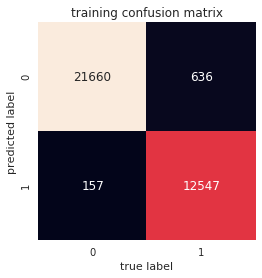

In [125]:
#look at training matrix
mat_t = confusion_matrix( y_train , preds_train_rf )
sns.heatmap(mat_t.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.title('training confusion matrix')
plt.ylabel('predicted label');

Not the best model since it is overfitting. We should tune.

# The tuning for the Random Forest parameters

First lets limit how much the model gets to split down the tree. We do this with max_depth. It should prevent us from fitting to every data point. We will also look at limiting the number of samples to be considered a leaf node. We overfit if each data point is a leaf.

In [126]:
#know lets tune the parameters for the random forest

#set parametets to tune in Random Grid Search (# depth of trees and # min samples per leaf)
parameters={'max_depth':range(1,100,10),'min_samples_leaf':[5,10,20,30,40,50,100]}

#create an instance of the random forest classifier
rf=RandomForestClassifier(class_weight= "balanced")

#randomize grid search for parameters with cross validation and refit on entire training set
#spread across two jobs and seed a random state
rs = RandomizedSearchCV(rf, param_distributions=parameters,cv=5,refit=True,n_jobs=2,random_state=42,scoring='f1')

#fit grid search on random forest over grid
%time rs.fit( x_train ,  y_train )

CPU times: user 560 ms, sys: 150 ms, total: 710 ms
Wall time: 4.63 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'max_depth': range(1, 100, 10), 'min_samples_leaf': [5, 10, 20, 30, 40, 50, 100]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [127]:
#save best parameters to use on test set
best_depth = rs.best_params_['max_depth'] 
best_leaf=rs.best_params_['min_samples_leaf'] 

#print best parameter results
print("the best depth of trees is {} with a minimum number of samples per leaf of {}".format( best_depth , best_leaf ))
print("the best f1 score with these is {}".format(rs.best_score_))

the best depth of trees is 31 with a minimum number of samples per leaf of 10
the best f1 score with these is 0.7130371589826524


# we can inspect learning curves to verify selections

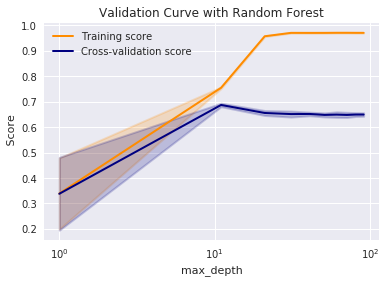

In [128]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters["max_depth"]
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, x_train, y_train, param_name="max_depth", param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("max_depth")
plt.ylabel(" Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

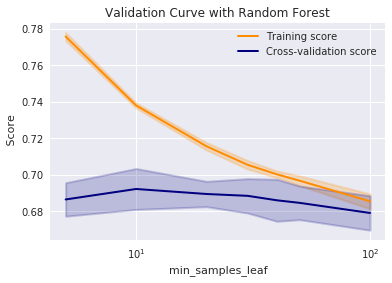

In [129]:
#save the range for the Random Forest n_estimators parameter to a variable
param_range= parameters['min_samples_leaf']
#get learning scores
train_scores, test_scores = validation_curve( clf_rf, x_train, y_train, param_name='min_samples_leaf', param_range= param_range , cv=10, scoring="f1", n_jobs=2 )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel('min_samples_leaf')
plt.ylabel(" Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [130]:
#create classifier from best parameters out of grid search
clf_rf=rs.best_estimator_
#fit classifier to validation set
clf_rf.fit(x_train,y_train)

#get the prediction set for the validation 
preds_train_rf = clf_rf.predict(x_train)

#make some predictions
preds_rf = clf_rf.predict(x_test)


#print the accuracy score for the training data
training_accuracy = clf_rf.score( x_train , y_train )
print("Accuracy on training data: {:0.2f}".format( training_accuracy ) )

#print the accuracy score for the test data
test_accuracy = clf_rf.score(x_test , y_test)
print("Accuracy on test data: {:0.2f}".format( test_accuracy ) )

#print training f1 score
fscore_train = metrics.f1_score( y_train , preds_train_rf )
print("F1 Score on train data: {:0.4f}".format(fscore_train))

#print testing f1 score
fscore = metrics.f1_score( y_test , preds_rf , pos_label=1 )
print("F1 Score on validation (train-test set) data: {:0.4f}".format( fscore ) )


print ( classification_report ( y_test , preds_rf ))

Accuracy on training data: 0.81
Accuracy on test data: 0.77
F1 Score on train data: 0.7552
F1 Score on validation (train-test set) data: 0.7046
             precision    recall  f1-score   support

          0       0.83      0.78      0.81      9379
          1       0.67      0.74      0.70      5621

avg / total       0.77      0.77      0.77     15000



We have reduced the overfitting greatly. The test and train score are much closer together indictating that we are not catching as much noise but more of the true pattern.

# Note the F1 Score:

.77 on the test set. We will use this in our model evalution. but First lets look at the confusion matrix, ROC, and AUC.


In [131]:
#look at confusion matrix
confusion_matrix( y_test , preds_rf )

array([[7355, 2024],
       [1463, 4158]])

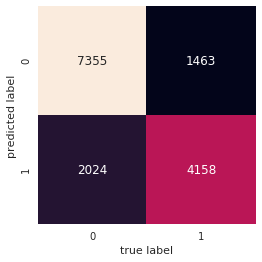

In [132]:
mat = confusion_matrix( y_test , preds_rf )
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

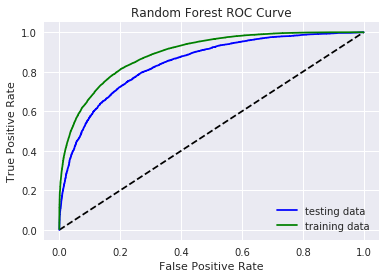

In [133]:
#predict the probabilities for each observation in training set
pred_train_prob_rf = clf_rf.predict_proba(x_train)[:,1]

#predict the probabilities for each observation in test set
pred_prob_rf = clf_rf.predict_proba(x_test)[:,1]

#get false positive rate, true positive rate, and thresholds for training data
xfpr_rf , xtpr_rf , xthres_rf = roc_curve(y_train , pred_train_prob_rf )

#get false positive rate, true positive rate, and thresholds for test data
fpr_rf , tpr_rf , thres_rf = roc_curve( y_test , pred_prob_rf )

#plot base line at .5 probability
plt.plot([0,1],[0,1],'k--')
#plot model train and test
plt.plot( fpr_rf , tpr_rf ,'blue',label='testing data')
plt.plot( xfpr_rf , xtpr_rf , 'g-',label='training data')
#add labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.legend(loc=4)
plt.show()

The ROC curve is best for binary classifiers which our model is. We see here that the model is performing well. The dashed black line represents random chance. Our model is doing much better. We could combine this with a  

The area under the curve (AUC) verifies this.

In [134]:
rf_test_auc=roc_auc_score(y_test , pred_prob_rf)
print("The Area Under the Curve for the Randam Forest is {:.2f}".format(rf_test_auc))

The Area Under the Curve for the Randam Forest is 0.84



# Model evaluation
The model performs well and an AUC of 0.84 is in an acceptable range of results to assert a valid model. 

Recall the F1 score .77 on the test set. 

This lower score can be contributed to the imbalance of positive cases which F1 score cares more about. ROC/AUC handles the case of few negative labels in the same way it handles the case of few positive labels. The F1 score care more about these miss labeled positive labels and scores the model lower. This score will be much more important in the future as we improve rider retention.

Before recommendations a which look at feature selection

# Looking at feature selection 

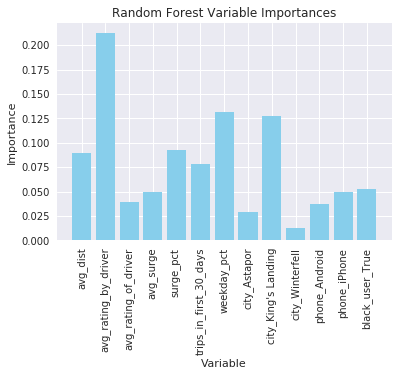

In [135]:
#Capture model feature importance 
importances=clf_rf.feature_importances_
#list to catch the top features
top=[]
#pair feature score with feature name
imp = (zip (features,importances))
for i in imp:
    #keep only features that have a positive value
    if i[1] > .001:
        top.append(i)
#get length of x axis 
x_values = list(range(len(top)))
#plot feature importance 
for i in range(len(top)):
    plt.bar( x_values, [pt[1] for pt in top], color='skyblue')
    plt.xticks(x_values, [pt[0] for pt in top],label = 'id %s'%i, rotation='vertical', fontsize=10)
    
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Random Forest Variable Importances');

#save figure
plt.savefig('feature_importance.png')
#show figure in notebook
plt.show()

### Concerns:

I do have concerns that that data only covers a small period. We would prefer to have a Concerns:

I do have concerns that that data only covers a small period. We would prefer to have a time span that contained many 6 month periods. This would reenforce help prevent the model from over fitting to just this one six month time span.

### Recommendations:

The largest drop of ridership was in Winterfell (also the largest market). We should look at operations there to see if anything is unique compared to the other two cities. 

Using the feature selection information. Driver rating "by" has a impact on on retention. We could look at providing coaching and customer interaction tips to drivers. We should partner with them to improve retention. Possible offering goals or incentives tied to new customer (first three rides) based off 6 month retention. A driver attitude toward customer is probably impacting the new rider, but not being caught in the driver rating "of". 

Surge percent is another strong indicator of retention. Riders probably are noticing the variance during peak hours which is creating a sense of resentment. Surge pricing should be capped, especially for new riders (first three rides).

### Next Steps:

I would look at comparing this model to different ones. Possible XGBoost or a regression. 

I would look at splitting out the bimodal parts of the histogram: New riders (less than 3 rides) and long term customers.

I would look at improving the model to handle imbalanced data better. examples stratifying the classes or resampling. 